# Corporación Favorita Grocery Sales Forecasting- LSTM

This notebook will build an LSTM model to predict the total number of transactions in future time periods.

In [1]:
import os
import gc
import pydot
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(1)
%matplotlib inline  

C:\Users\kikimeow\Anaconda3\envs\tf-music21\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load transactions data, which is the sum of unit_sales aggregated by store_nbr. 

In [2]:
transactions = pd.read_csv("C:/Users/kikimeow/OneDrive/OneDrive Documents/Kaggle/Kaggle- Supermarket/data/transactions.csv",
                          parse_dates=["date"])

Calculate total # of unit sales by date

In [3]:
data = transactions.groupby('date', as_index = False)['transactions'].sum()

In [4]:
data['transactions'].nsmallest(8)

0         770
364      1327
1455     1642
728      2202
1093    17829
23      63705
9       66383
268     66914
Name: transactions, dtype: int64

Remove outliers

In [5]:
#mask = data['transactions'] < 60000

In [6]:
#data = data[~mask].reset_index(drop = True)

#### Preprocess data

Parse data into X and Y.  

X: This is an (m,  Tx , 1) dimensional array. We have m training examples, each of which is a snippet of Tx sequence (timestep) of sales.  At each time step, the input is sales for the date.

Y: The data in Y has dimension (m, Ty)

This preprocessing method take a sequence of length Tx, and then output the next length of sequences determined by Ty.

In [7]:
def data_processing(data, n_values, Tx, Ty):
    """
    Function to preprocess data
    
    Arguments:
    data -- data
    m -- number of samples
    n_values -- # of dimensions of each value
    Tx -- length of sequence of X
    Ty -- length of sequence of Y
    
    Returns:
    Array X and Array Y
    """
    
    m = int((data.shape[0])/(Tx + Ty))
    
    # make empty array to store data
    X = np.zeros((m, Tx, n_values))
    Y = np.zeros((m, Ty))

    # initialize counters
    X_start = 0
    Y_start = 0
    
    for i in range(m):
        #print('sample:', i)
        Y_start = X_start+Tx
        xobs = X_start
        yobs = Y_start

        for tx in range(Tx):
            #print('tx:', tx)
            X[i, tx, 0] = data.iloc[xobs, 1]
            #print('X for i, tx:', X[i, tx, 0] )
            xobs+=1
            #print('xobs at the end:', xobs)

        for ty in range(Ty):
            #print('ty:', ty)
            Y[i, ty] = data.iloc[yobs, 1]
            #print('Y for i, ty:', Y[i, ty, 0] )
            yobs+=1
            #print('yobs at the end:', yobs)
    
        X_start = Y_start+Ty
    
    #Y = np.swapaxes(Y,0,1)
    #Y = Y.tolist()
    return np.asarray(X), np.asarray(Y)

In [8]:
def data_processing_redundant(data, Tx):
    
    '''cut the data into sequences of Tx values
    '''
    m = len(data)-Tx
    
    # make empty array to store data
    X = np.zeros((m, Tx, 1))
    Y = np.zeros((m, 1))
    
    for i in range(m):
        xobs = i
        yobs = i+Tx
        
        for tx in range(Tx):
            X[i, tx, 0] = data.iloc[xobs, 1]
            xobs+=1

        Y[i, 0] = data.iloc[yobs, 1]
    
    return np.asarray(X), np.asarray(Y)

### Scale data and divide dataset

Divide dataset in to train, valid, test

In [9]:
sampleRate = [0.8, 0.1, 0.1]
m = data.shape[0]
print('total rows: ', m)

total rows:  1682


Set sequence length

In [10]:
Tx = 28

In [11]:
X_train_unscaled, Y_train_unscaled = data_processing_redundant(data.iloc[0:round(m*sampleRate[0])], Tx = Tx)
X_valid_unscaled, Y_valid_unscaled = data_processing_redundant(data.iloc[round(m*sampleRate[0]):round(m*(sampleRate[0]+sampleRate[1])) ], Tx = Tx)
X_test_unscaled, Y_test_unscaled = data_processing_redundant(data.iloc[round(m*(sampleRate[0]+sampleRate[1])):], Tx = Tx)

In [12]:
print(X_train_unscaled.shape)
print(X_valid_unscaled.shape)
print(X_test_unscaled.shape)

(1318, 28, 1)
(140, 28, 1)
(140, 28, 1)


In [13]:
scale_min= data.iloc[0:round(m*sampleRate[0]),1].min()
scale_max= data.iloc[0:round(m*sampleRate[0]),1].max()
scale_diff = scale_max - scale_min

In [14]:
data_scaled = data
data_scaled['transactions'] = (data_scaled['transactions'] - scale_min)/ scale_diff

In [15]:
X_train, Y_train = data_processing_redundant(data_scaled.iloc[0:round(m*sampleRate[0])], Tx = Tx)
X_valid, Y_valid = data_processing_redundant(data_scaled.iloc[round(m*sampleRate[0]):round(m*(sampleRate[0]+sampleRate[1])) ], Tx = Tx)
X_test, Y_test = data_processing_redundant(data_scaled.iloc[round(m*(sampleRate[0]+sampleRate[1])):], Tx = Tx)

In [16]:
print('X_train shape:', X_train.shape)
print('X_test shape:',X_test.shape)
print('Y_train shape:',Y_train.shape)
print('Y_test shape:',Y_test.shape)
print('sample X_train unscaled:', X_train_unscaled[0][:5])
print('sample X_train scaled:', X_train[0][:5])

X_train shape: (1318, 28, 1)
X_test shape: (140, 28, 1)
Y_train shape: (1318, 1)
Y_test shape: (140, 1)
sample X_train unscaled: [[  770.]
 [93215.]
 [78504.]
 [78494.]
 [93573.]]
sample X_train scaled: [[0.        ]
 [0.54252079]
 [0.45618812]
 [0.45612944]
 [0.54462174]]


### Model - sequence to one

In [45]:
def model_seq_to_one(Tx, n_a1, n_a2, n_values):
    """
    Function creating the model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    n_a1 -- # of hidden units for LSTM layer 1
    n_a2 -- # of hidden units for LSTM layer 2
    n_values -- # of dimensions 

    Returns:
    model -- a model instance in Keras
    """
    

    # Define input of the graph
    X = Input(shape=(Tx, n_values), name='InputLayer')
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    x = LSTM(n_a1, return_sequences = True, name = 'LSTM_1')(X)
    
    # Add dropout with a probability
    x = Dropout(0.5, name = 'Dropout_1')(x)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    x = LSTM(n_a2, return_sequences = False, name = 'LSTM_2')(x)
    
    # Add dropout with a probability
    x = Dropout(0.5, name = 'Dropout_2')(x)
    
    # Propagate X through a Dense layer
    x = Dense(n_values, activation = 'relu', name = 'Dense_1')(x)
    
    # Create Model instance .
    model = Model(inputs= X, outputs = x, name='seq_to_one_model')
    
    ### END CODE HERE ###
    
    return model

In [62]:
model = model_seq_to_one(Tx = Tx, n_a1 = 64, n_a2 = 64, n_values=1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      (None, 28, 1)             0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 28, 64)            16896     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
Dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


Compile model and define what loss, optimizer and metrics to use

In [63]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer= opt, loss='mean_squared_error', metrics=['mae'])

Fit the Keras model on X_train and Y_train

In [64]:
model.fit(X_train, Y_train, epochs = 20 , batch_size = 50, validation_data = (X_valid, Y_valid))

Train on 1318 samples, validate on 140 samples
Epoch 1/20
1318/1318 [==============================] - 4s 3ms/step - loss: 0.0243 - mean_absolute_error: 0.1121 - val_loss: 0.0088 - val_mean_absolute_error: 0.0596
Epoch 2/20
1318/1318 [==============================] - 1s 934us/step - loss: 0.0085 - mean_absolute_error: 0.0712 - val_loss: 0.0090 - val_mean_absolute_error: 0.0602
Epoch 3/20
1318/1318 [==============================] - 1s 921us/step - loss: 0.0075 - mean_absolute_error: 0.0653 - val_loss: 0.0102 - val_mean_absolute_error: 0.0629
Epoch 4/20
1318/1318 [==============================] - 1s 963us/step - loss: 0.0071 - mean_absolute_error: 0.0644 - val_loss: 0.0092 - val_mean_absolute_error: 0.0606
Epoch 5/20
1318/1318 [==============================] - 1s 923us/step - loss: 0.0066 - mean_absolute_error: 0.0595 - val_loss: 0.0097 - val_mean_absolute_error: 0.0612
Epoch 6/20
1318/1318 [==============================] - 1s 898us/step - loss: 0.0064 - mean_absolute_error: 0.0592 

In [65]:
loss, mae = model.evaluate(X_test, Y_test)
print("loss= ", loss)
print("mae= ", mae)

140/140 [==============================] - 0s 344us/step
loss=  0.004234589164012245
mae=  0.04521065705588886


### Evaluate accurancy of predictions

In [66]:
pred = model.predict(X_test)

In [67]:
pred_unscaled = (scale_diff*pred) + scale_min

#### Test set performance

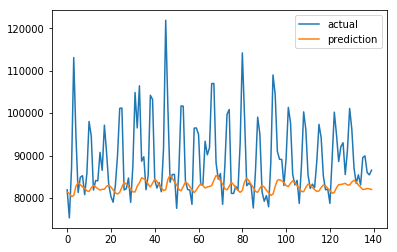

In [68]:
plt.plot(Y_test_unscaled)
plt.plot(pred_unscaled)
plt.legend(['actual', 'prediction'], loc='upper right')

#### Training set performance

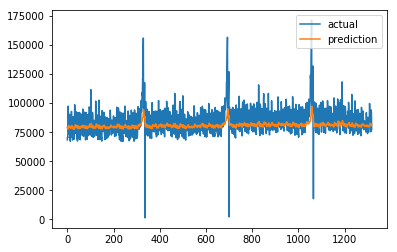

In [69]:
pred = model.predict(X_train)
pred_unscaled = (scale_diff*pred) + scale_min
plt.plot(Y_train_unscaled)
plt.plot(pred_unscaled)
plt.legend(['actual', 'prediction'], loc='upper right')

#### Generate sequence of predictions for the test set

Generate sequence of predictions starting from the last observation in the validation set. 

In [70]:
newX = np.zeros((1, Tx, 1))
lastX = X_valid[[-1]]
predictions = []

for i in range(len(X_test)):
    pred = model.predict(lastX)
    
    for tx in range(Tx):
        if tx < Tx-1:
            newX[0, tx, 0] = lastX[0][tx+1]
        else:
            newX[0, tx, 0] = pred[0][0]
    predictions.append(pred[0][0])
    lastX = newX
    

In [71]:
pred = pd.DataFrame(data= predictions, columns=['unscaled_pred'])
pred['scaled_actual'] = Y_test_unscaled

In [72]:
pred['scaled_pred'] = (pred['unscaled_pred']*scale_diff) + scale_min

In [73]:
pred.head()

,unscaled_pred,scaled_actual,scaled_pred
0,0.474385,81918.0,81604.794494
1,0.472003,75304.0,81198.907412
2,0.470150,87034.0,80883.098967
3,0.468735,113083.0,80641.981950
4,0.467658,94696.0,80458.533949


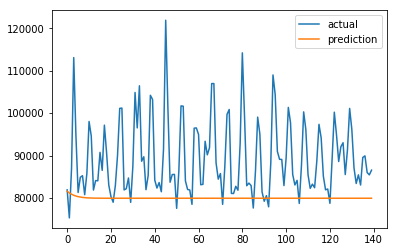

In [74]:
plt.plot(pred['scaled_actual'])
plt.plot(pred['scaled_pred'])
plt.legend(['actual', 'prediction'], loc='upper right')

### Building the model

Build a model that takes in X of shape(m,Tx,1) and Y of shape (Ty,m,1) with number of hidden states defined by n_a and number of dimensions of data by n_values

In [31]:
n_a = 64 
n_values = 1 

Define the layer objects for the lstm_model.

In [32]:
reshapor = Reshape((1, 1)) #Reshape((1, n_values))                    
LSTM_cell = LSTM(n_a, return_state = True)        
densor = Dense(n_values, activation='linear')  

The function lstm_model() will call the LSTM layer Tx times using a for-loop.  The  Tx  steps should have shared weights. 

In [33]:
def lstm_model(Tx, n_a, n_values):
    """
    Implement the model
    
    Arguments:
    Tx -- length of the sequence in a corpus
    n_a -- the number of activations used in our model
    n_values -- numer of values
    
    Returns:
    model -- a keras model with the 
    """
    
    # Define the input of your model with a shape 
    X = Input(shape=(Tx, n_values))  # n_values is number of dimensions
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
    # Step 1: Create empty list to append the outputs while you iterate
    outputs = []
    
    # Step 2: Loop
    for t in range(Tx):
        
        # Step 2.A: select the "t"th time step vector from X. 
        x = Lambda(lambda x: X[:,t,:])(X)
        # Step 2.B: Use reshapor to reshape x to be (1, n_values)
        x = reshapor(x)
        # Step 2.C: Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        # Step 2.D: Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)  
        # Step 2.E: add the output to "outputs"
        outputs.append(out)
        
    # Step 3: Create model instance
    model = Model(inputs = [X, a0, c0], outputs = outputs, name='lstm_model')
    
    return model

In [34]:
model = lstm_model(Tx = Tx , n_a = n_a, n_values = n_values)

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 1)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 1)         0           lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]                   
                                                                 lambda_4[0][0]                   
          

In [36]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

In [37]:
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [38]:
model.fit([X, a0, c0], list(Y), epochs=100)

NameError: name 'X' is not defined

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))